In [1]:
!wget https://www.dropbox.com/s/7p88tb8aqcuuztm/negative.csv?dl=0 -O negative.csv
!wget https://www.dropbox.com/s/pkv5b8jvo4j9je3/positive.csv?dl=0 -O positive.csv 

--2021-12-10 20:14:05--  https://www.dropbox.com/s/7p88tb8aqcuuztm/negative.csv?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:601b:18::a27d:812
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/7p88tb8aqcuuztm/negative.csv [following]
--2021-12-10 20:14:06--  https://www.dropbox.com/s/raw/7p88tb8aqcuuztm/negative.csv
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc44a4588eeb28b00ec1202294b4.dl.dropboxusercontent.com/cd/0/inline/BblXncegq3pQNPDpNI2W3YfAapIpfIf4Lqivof3q7JkUakfJw2XHeUBKejEcyqp8z8n5IEmrYYa0ICIMSuCwnTVhloht5E8CE7unKILyAc5mH1GaCNgPpz1jXpbWyobC__cosW8kJYskFRoY2iUQK77p/file# [following]
--2021-12-10 20:14:06--  https://uc44a4588eeb28b00ec1202294b4.dl.dropboxusercontent.com/cd/0/inline/BblXncegq3pQNPDpNI2W3YfAapIpfIf4Lqivof3q7JkUakfJw2XHeUBKejEcyqp8z8n5IEmrYYa0ICIMSuCwn

In [2]:
!pip install torchmetrics

     |████████████████████████████████| 332 kB 5.4 MB/s 


In [3]:
!pip install ipdb

     |████████████████████████████████| 791 kB 6.7 MB/s 
     |████████████████████████████████| 374 kB 37.4 MB/s 
  Created wheel for ipdb: filename=ipdb-0.13.9-py3-none-any.whl size=11648 sha256=7c65997d707e31158aaa3a2d495c954f53214cd141acf56504999202854e52a6
  Stored in directory: /root/.cache/pip/wheels/65/cd/cc/aaf92acae337a28fdd2aa4d632196a59745c8c39f76eaeed01
Successfully built ipdb
  Attempting uninstall: prompt-toolkit
    Found existing installation: prompt-toolkit 1.0.18
    Uninstalling prompt-toolkit-1.0.18:
      Successfully uninstalled prompt-toolkit-1.0.18
  Attempting uninstall: ipython
    Found existing installation: ipython 5.5.0
    Uninstalling ipython-5.5.0:
      Successfully uninstalled ipython-5.5.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jupyter-console 5.2.0 requires prompt-toolkit<2.0.0,>=1.0.0, but you have prompt-toolkit 

In [4]:
import re
import pandas as pd
import numpy as np
from string import punctuation
punctuation += '...' + '—' + '…' + '«»'

from collections import Counter
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from torch.nn.utils.rnn import pad_sequence
import torch.optim as optim
from torchmetrics import F1
from torchmetrics.functional import f1, recall
import ipdb

In [5]:
pos_tweets = pd.read_csv('positive.csv', encoding='utf-8', sep=';', header=None,  names=[0,1,2,'text','tone',5,6,7,8,9,10,11])
neg_tweets = pd.read_csv('negative.csv', encoding='utf-8', sep=';', header=None, names=[0,1,2,'text','tone',5,6,7,8,9,10,11] )
neg_tweets['tone'] = 0

In [6]:
all_tweets_data = pos_tweets.append(neg_tweets)
print(len(all_tweets_data))

226834


In [7]:
tweets_data = shuffle(all_tweets_data[['text','tone']])[:100000]

In [8]:
train_sentences, val_sentences = train_test_split(tweets_data, test_size=0.1)

In [9]:
train_sentences

,text,tone
16263,"RT @Apollo_Loki: @Loki_Killjoy Крылышко, у теб...",1
10101,Офигенный день!\nдень позитива)\nбегал как иди...,1
102997,Лентааа я не помню свой пороль...сижу только с...,0
87291,RT @Natasha_Rudova: Наконец-то дома)))Журнальч...,1
101604,@skemhey а здоровье? не всякое купишь за деньги(,0
...,...,...
88222,"относитесь к сексу с юмором: не встал, похохот...",1
100516,"Мама,когда же ты уже научишься себя беречь:(",0
23335,"А ещё я сегодня чуток кое-кому приврала, потом...",0
83055,"Сначала не хотела чтобы каникулы начинались,а ...",0


In [10]:
def preprocess(text): 
    text = text.lower()
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', 'URL', text)
    text = re.sub('@[^\s]+', 'USER', text)
    return text.split()

In [11]:
tweets_data['preprocessed'] = tweets_data.text.apply(lambda x: ' '.join(preprocess(x)))

In [12]:
train_sentences, val_sentences = train_test_split(tweets_data, test_size=0.1)

In [13]:
train_sentences

,text,tone,preprocessed
3590,"@aduckevich пипец, каждый день мимо хожу и не ...",1,"USER пипец, каждый день мимо хожу и не узнала...."
103959,Завтра нужно подойти до учительницы английског...,0,завтра нужно подойти до учительницы английског...
31281,глупая маленькая девочка :D вот убивают такие ...,1,глупая маленькая девочка :d вот убивают такие ...
94653,"К сожалению, в iPhone нет основной и единствен...",0,"к сожалению, в iphone нет основной и единствен..."
106405,Быстрее бы этот год уже закончился. Я - слабак...,1,быстрее бы этот год уже закончился. я - слабак...
...,...,...,...
93513,"Сделать то , что я пыталась сделать все канику...",0,"сделать то , что я пыталась сделать все канику..."
49302,@Muravejchik сайлент хилл? Фредди против Джейс...,0,USER сайлент хилл? фредди против джейсона? тех...
21199,RT @Dallisnotonfire: @viktorysmail5 ой))))) сы...,1,rt USER USER ой))))) сына тоже можно будет наз...
8627,"Иногда бесит, но ничего не попишешь :)\nЭто же...",1,"иногда бесит, но ничего не попишешь :) это же ..."


In [14]:
vocab = Counter()

for text in tweets_data['text']:
    vocab.update(preprocess(text))
print('всего уникальных токенов:', len(vocab))

всего уникальных токенов: 226970


In [15]:
tweets_data

,text,tone,preprocessed
73510,@korovka_mu_mu та шик\nхавка тви салюты\nта эт...,0,USER та шик хавка тви салюты та это бы самый л...
3770,RT @Lezhnevs: Оказывается нашу жизнь можно оха...,1,rt USER оказывается нашу жизнь можно охарактер...
103024,Михримах...нет.(((\nнельзя выходить замуж на з...,0,михримах...нет.((( нельзя выходить замуж на зл...
91018,В свежей серии гриффинов у Питера медиатор в д...,1,в свежей серии гриффинов у питера медиатор в д...
12174,делать совсем нечего( http://t.co/ryvuUSg6F9,0,делать совсем нечего( URL
...,...,...,...
24814,Разачароваться в человеке ничего не стоит 5 ми...,0,разачароваться в человеке ничего не стоит 5 ми...
59464,@chriscalfer @jenahendersona Колфер дело говор...,1,USER USER колфер дело говорит. я же программис...
53774,@MatweeAlexeev был бы шум белым - было б здоро...,0,USER был бы шум белым - было б здорово. тут на...
72793,@J_Farafoshina я тоже уже сдохну скоро с этим...,1,USER я тоже уже сдохну скоро с этим дз. а у ме...


In [16]:
filtered_vocab = set()

for word in vocab:
    if vocab[word] > 5:
        filtered_vocab.add(word)
print('уникальных токенов, втретившихся больше 5 раз:', len(filtered_vocab))

уникальных токенов, втретившихся больше 5 раз: 14417


In [17]:
#создаем словарь с индексами word2id, для спецсимвола паддинга дефолтный индекс - 0
word2id = {'PAD':0}

for word in filtered_vocab:
    word2id[word] = len(word2id)

In [18]:
#обратный словарь для того, чтобы раскодировать последовательность
id2word = {i:word for word, i in word2id.items()}

In [19]:
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
DEVICE

device(type='cuda')

In [30]:
class TweetsDataset(Dataset):

    def __init__(self, dataset, word2id, DEVICE):
        self.dataset = dataset['preprocessed'].values
        self.word2id = word2id
        self.length = dataset.shape[0]
        self.target = torch.Tensor(dataset['tone'].values)
        self.device = DEVICE

    def __len__(self): 
        return self.length

    def __getitem__(self, index):
        tokens = self.dataset[index].split()
        ids = torch.LongTensor([self.word2id[token] for token in tokens if token in self.word2id])
        y = [self.target[index]]
        return ids, y

    def collate_fn(self, batch):
        ids, y = list(zip(*batch))
        padded_ids = pad_sequence(ids, batch_first=True).to(self.device)
        y = torch.Tensor(y).to(self.device)
        return padded_ids, y

In [31]:
train_dataset = TweetsDataset(train_sentences, word2id, DEVICE)
train_sampler = RandomSampler(train_dataset)
train_iterator = DataLoader(train_dataset, collate_fn = train_dataset.collate_fn, sampler=train_sampler, batch_size=1024)

In [32]:
val_dataset = TweetsDataset(val_sentences, word2id, DEVICE)
val_sampler = SequentialSampler(val_dataset)
val_iterator = DataLoader(val_dataset, collate_fn = val_dataset.collate_fn, sampler=val_sampler, batch_size=1024)

In [ ]:
batch = next(iter(train_iterator))
val_batch = next(iter(val_iterator))

In [24]:
batch

(tensor([[11565, 10327,  8184,  ...,     0,     0,     0],
         [12822,  9668,  6378,  ...,     0,     0,     0],
         [ 3288,  1351, 14387,  ...,     0,     0,     0],
         ...,
         [  942, 12708, 12555,  ...,     0,     0,     0],
         [ 9019,  3775, 10287,  ...,     0,     0,     0],
         [ 2497,  8838,  5493,  ...,     0,     0,     0]], device='cuda:0'),
 tensor([[1.],
         [1.],
         [0.],
         ...,
         [0.],
         [1.],
         [1.]], device='cuda:0'))

In [20]:
def train(train_dataloader, val_dataloader, model, optimizer, criterion, 
          NUM_EPOCHS, metric, device=DEVICE):
    
    model.to(device)

    losses = []
    val_losses = []
    f1scores = []
    val_f1scores = []

    for epoch in range(NUM_EPOCHS):
        print("")
        print('======== Epoch {:} / {:} ========'.format(epoch + 1, NUM_EPOCHS))

        model.train()  
        print('\nTraining...')

    # ========================================
    #               Training
    # ========================================

        epoch_loss = [] 
        epoch_metric = []

        for i, (*x, y) in enumerate(train_dataloader, 1):
            optimizer.zero_grad()
            preds = model(*x)
            loss = criterion(preds, y)
            loss.backward()
            optimizer.step()
            epoch_loss.append(loss.item())
            batch_metric = metric(preds.round().long(), y.long(), ignore_index=0)
            epoch_metric.append(batch_metric.cpu().numpy())
        losses.extend(epoch_loss)
        f1scores.extend(epoch_metric)

        print('Train loss: ', np.mean(epoch_loss))
        print('Train metric: ', np.mean(epoch_metric))

        val_loss, val_metric = evaluate(val_dataloader, model, criterion, metric, device)
        val_losses.extend(val_loss)
        val_f1scores.extend(val_metric)

    return losses, f1scores, val_losses, val_f1scores


def evaluate(dataloader, model, criterion, metric, device=DEVICE):
    
    print('\n~/~/~/~/~/~/~/~/~/~/~/~/~/~/~/~')
    print('\nValidation...')
    # ========================================
    #               Validation
    # ========================================
    epoch_loss = []
    epoch_metric = []
    model.eval() 

    with torch.no_grad():
        for i, (*x, y) in enumerate(dataloader):
            preds = model(*x)
            loss = criterion(preds, y)
            epoch_loss.append(loss.item())
            batch_metric = metric(preds.round().long(), y.long(), ignore_index=0)
            epoch_metric.append(batch_metric.cpu().numpy())
    
    print('Val loss: ', np.mean(epoch_loss))
    print('Val metric: ', np.mean(epoch_metric))
        
    return epoch_loss, epoch_metric

In [29]:
class myCNN_1(nn.Module):
    
    def __init__(self, vocab_size, embedding_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.bigrams = nn.Conv1d(in_channels=embedding_dim, out_channels=50, kernel_size=2, padding='same')
        self.trigrams = nn.Conv1d(in_channels=embedding_dim, out_channels=70, kernel_size=3, padding='same')
        self.sec_conv = nn.Conv1d(in_channels=120, out_channels=30, kernel_size=3, padding='same')
        self.pooling = nn.MaxPool1d(kernel_size=2, stride=1)
        self.relu = nn.ReLU()
        self.hidden = nn.Linear(in_features=30, out_features=1)
        self.out = nn.Sigmoid()

    def forward(self, word):
        embedded = self.embedding(word)
        embedded = embedded.transpose(1,2)
        feature_map_bigrams = self.relu(self.bigrams(embedded))
        feature_map_trigrams = self.relu(self.trigrams(embedded))
        concat = torch.cat((feature_map_bigrams, feature_map_trigrams), 1)
        concat = self.pooling(self.relu(self.sec_conv(concat)))
        pooling1 = concat.max(2)[0]
        logits = self.hidden(pooling1) 
        logits = self.out(logits)    
        return logits

In [ ]:
model = myCNN_1(len(word2id), 100)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()


train_loss, train_f1, val_loss, val_f1 = train(train_dataloader=train_iterator,
                                               val_dataloader=val_iterator,
                                               model=model,
                                               optimizer=optimizer,
                                               criterion=criterion,
                                               NUM_EPOCHS=10,
                                               metric=f1)


======== Epoch 1 / 10 ========

Training...
Train loss:  0.5330585833977569
Train metric:  0.7177462

~/~/~/~/~/~/~/~/~/~/~/~/~/~/~/~

Validation...
Val loss:  0.46784428358078
Val metric:  0.75311196

======== Epoch 2 / 10 ========

Training...
Train loss:  0.4367589794776656
Train metric:  0.7713154

~/~/~/~/~/~/~/~/~/~/~/~/~/~/~/~

Validation...
Val loss:  0.42142696380615235
Val metric:  0.7836741

======== Epoch 3 / 10 ========

Training...
Train loss:  0.3890229361978444
Train metric:  0.80409545

~/~/~/~/~/~/~/~/~/~/~/~/~/~/~/~

Validation...
Val loss:  0.3991921961307526
Val metric:  0.7961368

======== Epoch 4 / 10 ========

Training...
Train loss:  0.3541033200242303
Train metric:  0.8255749

~/~/~/~/~/~/~/~/~/~/~/~/~/~/~/~

Validation...
Val loss:  0.38349699378013613
Val metric:  0.80413306

======== Epoch 5 / 10 ========

Training...
Train loss:  0.3194840110161088
Train metric:  0.8470015

~/~/~/~/~/~/~/~/~/~/~/~/~/~/~/~

Validation...
Val loss:  0.38045271635055544
Val 

In [ ]:
import matplotlib.pyplot as plt

def show_results(train_loss, train_f1, val_loss, val_f1):
  plt.figure(figsize=(8, 6))
  plt.plot(train_loss)
  plt.plot(train_f1)
  plt.title('TRAIN')
  plt.ylabel('score')
  plt.xlabel('iterations')
  plt.grid()
  plt.legend(['loss', 'f1-score'], loc='upper right')
  plt.show()
  
  plt.figure(figsize=(8, 6))
  plt.plot(val_loss)
  plt.plot(val_f1)
  plt.title('TEST')
  plt.ylabel('score')
  plt.xlabel('iterations')
  plt.grid()
  plt.legend(['loss', 'f1-score'], loc='upper right')
  plt.show()

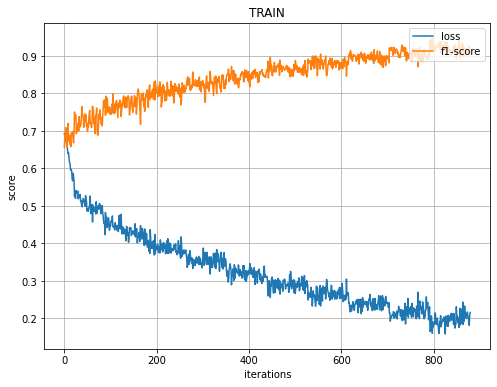

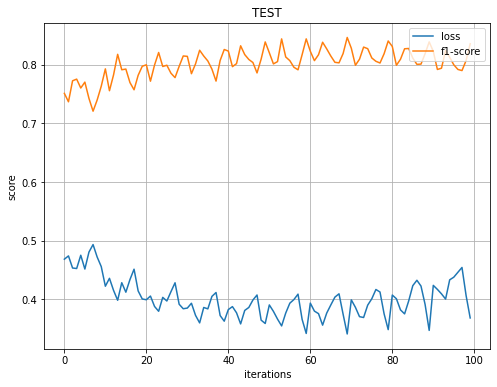

In [ ]:
show_results(train_loss, train_f1, val_loss, val_f1)

по графику видно, что в какой-то момент лосс начинает расти, мы переобучаемся..

попробуем добавить дропаутов

In [ ]:
class myCNN_1(nn.Module):
    
    def __init__(self, vocab_size, embedding_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.bigrams = nn.Conv1d(in_channels=embedding_dim, out_channels=50, kernel_size=2, padding='same')
        self.trigrams = nn.Conv1d(in_channels=embedding_dim, out_channels=70, kernel_size=3, padding='same')
        self.sec_conv = nn.Conv1d(in_channels=120, out_channels=30, kernel_size=3, padding='same')
        self.pooling = nn.MaxPool1d(kernel_size=2, stride=1)
        self.relu = nn.ReLU()
        self.hidden = nn.Linear(in_features=30, out_features=1)
        self.dropout = nn.Dropout(p=0.5)
        self.out = nn.Sigmoid()

    def forward(self, word):
        embedded = self.embedding(word)
        embedded = embedded.transpose(1,2)
        feature_map_bigrams = self.dropout(self.relu(self.bigrams(embedded)))
        feature_map_trigrams = self.dropout(self.relu(self.trigrams(embedded)))
        concat = torch.cat((feature_map_bigrams, feature_map_trigrams), 1)
        concat = self.pooling(self.relu(self.sec_conv(concat)))
        pooling1 = concat.max(2)[0]
        logits = self.hidden(pooling1) 
        logits = self.out(logits)    
        return logits

In [ ]:
model = myCNN_1(len(word2id), 100)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()


train_loss, train_f1, val_loss, val_f1 = train(train_dataloader=train_iterator,
                                               val_dataloader=val_iterator,
                                               model=model,
                                               optimizer=optimizer,
                                               criterion=criterion,
                                               NUM_EPOCHS=10,
                                               metric=f1)


======== Epoch 1 / 10 ========

Training...
Train loss:  0.5881347561424429
Train metric:  0.66985106

~/~/~/~/~/~/~/~/~/~/~/~/~/~/~/~

Validation...
Val loss:  0.49451699256896975
Val metric:  0.71274906

======== Epoch 2 / 10 ========

Training...
Train loss:  0.4717236825010993
Train metric:  0.749588

~/~/~/~/~/~/~/~/~/~/~/~/~/~/~/~

Validation...
Val loss:  0.4337932676076889
Val metric:  0.76964664

======== Epoch 3 / 10 ========

Training...
Train loss:  0.4236778098751198
Train metric:  0.78160894

~/~/~/~/~/~/~/~/~/~/~/~/~/~/~/~

Validation...
Val loss:  0.4090371817350388
Val metric:  0.77768755

======== Epoch 4 / 10 ========

Training...
Train loss:  0.3922517452050339
Train metric:  0.80121094

~/~/~/~/~/~/~/~/~/~/~/~/~/~/~/~

Validation...
Val loss:  0.38959996700286864
Val metric:  0.79184306

======== Epoch 5 / 10 ========

Training...
Train loss:  0.3669559508562088
Train metric:  0.8164099

~/~/~/~/~/~/~/~/~/~/~/~/~/~/~/~

Validation...
Val loss:  0.37817096412181855

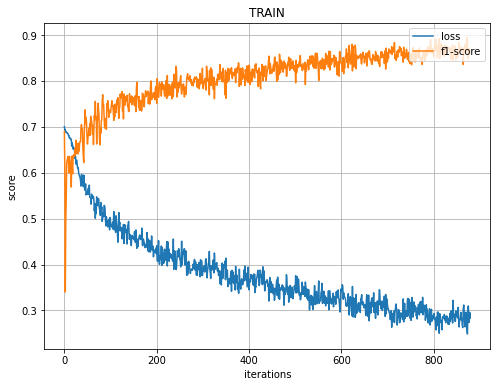

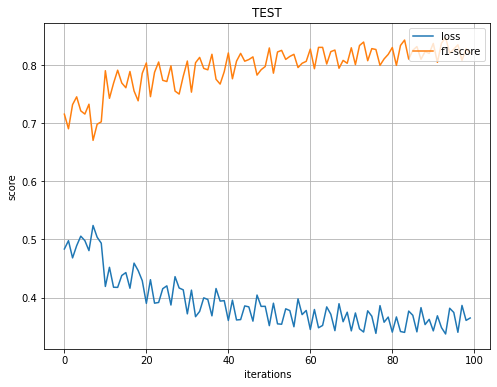

In [ ]:
show_results(train_loss, train_f1, val_loss, val_f1)

кажется уже лучше, может еще чуть-чуть дропаута..

In [ ]:
class myCNN_1(nn.Module):
    
    def __init__(self, vocab_size, embedding_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.bigrams = nn.Conv1d(in_channels=embedding_dim, out_channels=50, kernel_size=2, padding='same')
        self.trigrams = nn.Conv1d(in_channels=embedding_dim, out_channels=70, kernel_size=3, padding='same')
        self.sec_conv = nn.Conv1d(in_channels=120, out_channels=30, kernel_size=3, padding='same')
        self.pooling = nn.MaxPool1d(kernel_size=2, stride=1)
        self.relu = nn.ReLU()
        self.hidden = nn.Linear(in_features=30, out_features=1)
        self.dropout = nn.Dropout(p=0.5)
        self.out = nn.Sigmoid()

    def forward(self, word):
        embedded = self.embedding(word)
        embedded = embedded.transpose(1,2)
        feature_map_bigrams = self.dropout(self.relu(self.bigrams(embedded)))
        feature_map_trigrams = self.dropout(self.relu(self.trigrams(embedded)))
        concat = torch.cat((feature_map_bigrams, feature_map_trigrams), 1)
        concat = self.dropout(self.pooling(self.relu(self.sec_conv(concat))))
        pooling1 = concat.max(2)[0]
        logits = self.hidden(pooling1) 
        logits = self.out(logits)    
        return logits

In [ ]:
model = myCNN_1(len(word2id), 100)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()


train_loss, train_f1, val_loss, val_f1 = train(train_dataloader=train_iterator,
                                               val_dataloader=val_iterator,
                                               model=model,
                                               optimizer=optimizer,
                                               criterion=criterion,
                                               NUM_EPOCHS=10,
                                               metric=f1)


======== Epoch 1 / 10 ========

Training...
Train loss:  0.5942642333155329
Train metric:  0.6551035

~/~/~/~/~/~/~/~/~/~/~/~/~/~/~/~

Validation...
Val loss:  0.5137253761291504
Val metric:  0.7359711

======== Epoch 2 / 10 ========

Training...
Train loss:  0.47361594303087756
Train metric:  0.748892

~/~/~/~/~/~/~/~/~/~/~/~/~/~/~/~

Validation...
Val loss:  0.4599021583795547
Val metric:  0.770732

======== Epoch 3 / 10 ========

Training...
Train loss:  0.42801194570281287
Train metric:  0.77753884

~/~/~/~/~/~/~/~/~/~/~/~/~/~/~/~

Validation...
Val loss:  0.43108320236206055
Val metric:  0.7902848

======== Epoch 4 / 10 ========

Training...
Train loss:  0.39548435333100235
Train metric:  0.79918855

~/~/~/~/~/~/~/~/~/~/~/~/~/~/~/~

Validation...
Val loss:  0.4091333419084549
Val metric:  0.8045704

======== Epoch 5 / 10 ========

Training...
Train loss:  0.36932189390063286
Train metric:  0.8151915

~/~/~/~/~/~/~/~/~/~/~/~/~/~/~/~

Validation...
Val loss:  0.3943906515836716
Val

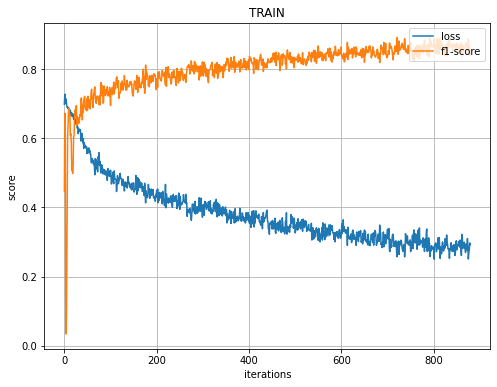

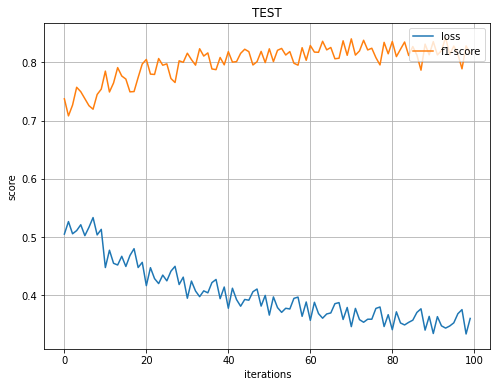

In [ ]:
show_results(train_loss, train_f1, val_loss, val_f1)

какжется теперь еще лучше, попробуем изменить размер фильтров, чтобы улучшить качество

In [ ]:
class myCNN_1(nn.Module):
    
    def __init__(self, vocab_size, embedding_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.bigrams = nn.Conv1d(in_channels=embedding_dim, out_channels=70, kernel_size=2, padding='same')
        self.trigrams = nn.Conv1d(in_channels=embedding_dim, out_channels=100, kernel_size=3, padding='same')
        self.sec_conv = nn.Conv1d(in_channels=170, out_channels=40, kernel_size=3, padding='same')
        self.pooling = nn.MaxPool1d(kernel_size=2, stride=1)
        self.relu = nn.ReLU()
        self.hidden = nn.Linear(in_features=40, out_features=1)
        self.dropout = nn.Dropout(p=0.5)
        self.out = nn.Sigmoid()

    def forward(self, word):
        embedded = self.embedding(word)
        embedded = embedded.transpose(1,2)
        feature_map_bigrams = self.dropout(self.relu(self.bigrams(embedded)))
        feature_map_trigrams = self.dropout(self.relu(self.trigrams(embedded)))
        concat = torch.cat((feature_map_bigrams, feature_map_trigrams), 1)
        concat = self.dropout(self.pooling(self.relu(self.sec_conv(concat))))
        pooling1 = concat.max(2)[0]
        logits = self.hidden(pooling1) 
        logits = self.out(logits)    
        return logits

In [ ]:
model = myCNN_1(len(word2id), 100)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()


train_loss, train_f1, val_loss, val_f1 = train(train_dataloader=train_iterator,
                                               val_dataloader=val_iterator,
                                               model=model,
                                               optimizer=optimizer,
                                               criterion=criterion,
                                               NUM_EPOCHS=10,
                                               metric=f1)


======== Epoch 1 / 10 ========

Training...
Train loss:  0.5747920847074552
Train metric:  0.6665956

~/~/~/~/~/~/~/~/~/~/~/~/~/~/~/~

Validation...
Val loss:  0.5090618818998337
Val metric:  0.7594315

======== Epoch 2 / 10 ========

Training...
Train loss:  0.47236116365952924
Train metric:  0.7479296

~/~/~/~/~/~/~/~/~/~/~/~/~/~/~/~

Validation...
Val loss:  0.4561470776796341
Val metric:  0.77631515

======== Epoch 3 / 10 ========

Training...
Train loss:  0.4300032359632579
Train metric:  0.7758985

~/~/~/~/~/~/~/~/~/~/~/~/~/~/~/~

Validation...
Val loss:  0.42860797345638274
Val metric:  0.7891872

======== Epoch 4 / 10 ========

Training...
Train loss:  0.3994284448298541
Train metric:  0.79522616

~/~/~/~/~/~/~/~/~/~/~/~/~/~/~/~

Validation...
Val loss:  0.40887041985988615
Val metric:  0.79775655

======== Epoch 5 / 10 ========

Training...
Train loss:  0.37415684590285475
Train metric:  0.8112677

~/~/~/~/~/~/~/~/~/~/~/~/~/~/~/~

Validation...
Val loss:  0.39673197865486143


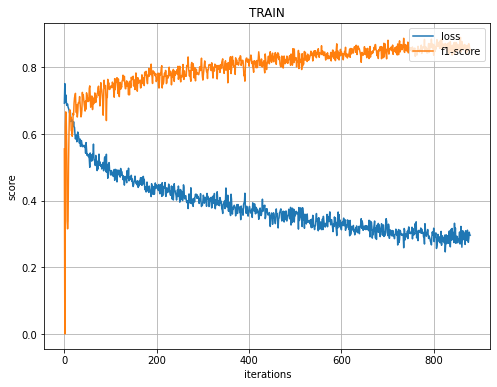

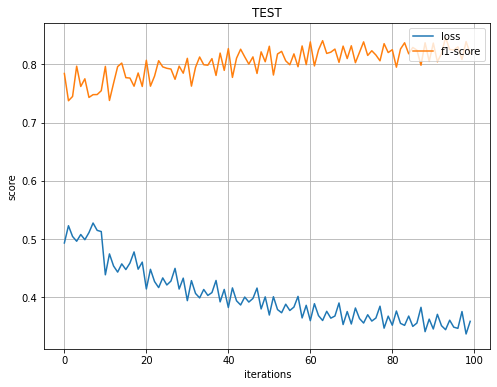

In [ ]:
show_results(train_loss, train_f1, val_loss, val_f1)

супер, качество улучшилось

# 2 часть

In [21]:
sym_vocab = Counter()
for text in tweets_data['preprocessed']:
    sym_vocab.update(list(text))
print('всего уникальных символов:', len(sym_vocab))

всего уникальных символов: 293


In [22]:
filtered_sym_vocab = set()

for word in sym_vocab:
    if vocab[word] > 1:
        filtered_sym_vocab.add(word)
print('уникальных символов, втретившихся больше 1 раза:', len(filtered_sym_vocab))

уникальных символов, втретившихся больше 1 раза: 110


In [23]:
symbol2id = {'PAD':0}

for word in filtered_sym_vocab:
    symbol2id[word] = len(symbol2id)+1

id2symbol = {i:word for word, i in symbol2id.items()}

In [24]:
class TweetsDatasetWS(Dataset):
    def __init__(self, dataset, word2id, symb2id, DEVICE):
        self.dataset = dataset['preprocessed'].values
        self.word2id = word2id
        self.symbol2id = symbol2id
        self.length = dataset.shape[0]
        self.target = torch.Tensor(dataset['tone'].values)
        self.device = DEVICE

    def __len__(self):
        return self.length

    def __getitem__(self, index): 
        words = self.dataset[index].split()
        word_ids = torch.LongTensor([self.word2id[word] for word in words if word in self.word2id])
        symbols = list(self.dataset[index])
        symbols_ids = torch.LongTensor([self.symbol2id[symbol] if symbol in symbol2id else 1 for symbol in symbols])
        y = [self.target[index]]
        return word_ids, symbols_ids, y

    def collate_fn(self, batch):
      word_ids, symbols_ids, y = list(zip(*batch))
      padded_word_ids = pad_sequence(word_ids, batch_first=True).to(self.device)
      padded_symbols_ids = pad_sequence(symbols_ids, batch_first=True).to(self.device)
      y = torch.Tensor(y).to(self.device)
      return padded_word_ids, padded_symbols_ids, y

In [25]:
train_dataset = TweetsDatasetWS(train_sentences, word2id, symbol2id, DEVICE)
train_sampler = RandomSampler(train_dataset)
train_iterator = DataLoader(train_dataset, collate_fn = train_dataset.collate_fn, sampler=train_sampler, batch_size=1024)

In [26]:
val_dataset = TweetsDatasetWS(val_sentences, word2id, symbol2id, DEVICE)
val_sampler = SequentialSampler(val_dataset)
val_iterator = DataLoader(val_dataset, collate_fn = val_dataset.collate_fn, sampler=val_sampler, batch_size=1024)

In [32]:
from gensim.models import FastText

In [33]:
model = FastText(sentences=tweets_data['preprocessed'].values, size=100)

In [34]:
weights = np.zeros((len(word2id), 100))
count = 0
for word, i in word2id.items():
    if word == 'PAD':
        continue   
    try:
        weights[i] = model.wv[word] 
    except KeyError:

        count += 1
      # oov словам сопоставляем случайный вектор
        weights[i] = np.random.normal(0,0.1,100)

In [27]:
class myCNN_2(nn.Module):
    def __init__(self, word_vocab_size, symbols_vocab_size, word_embedding_dim, 
                 symbols_embedding_dim, weights=False): 
        super().__init__()
        self.embedding = nn.Embedding(word_vocab_size, word_embedding_dim)
        if weights:
            self.embedding.from_pretrained(torch.tensor(weights), freeze=True)
        self.linear = nn.Linear(in_features=word_embedding_dim, out_features=140)
        self.symb_embedding = nn.Embedding(symbols_vocab_size, symbols_embedding_dim)
        self.bigrams = nn.Conv1d(in_channels=symbols_embedding_dim, out_channels=50, kernel_size=2, padding='same')
        self.trigrams = nn.Conv1d(in_channels=symbols_embedding_dim, out_channels=70, kernel_size=3, padding='same')
        self.pooling = nn.MaxPool1d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()
        self.hidden = nn.Linear(in_features=260, out_features=1)
        self.out = nn.Sigmoid()
    
    def forward(self, sentence, symbols):
        sentence = self.linear(self.embedding(sentence).mean(axis=1))
        symbols = self.symb_embedding(symbols)
        symbols = symbols.transpose(1,2)
        feature_map_bigrams = self.pooling(self.relu(self.bigrams(symbols)))
        feature_map_trigrams = self.pooling(self.relu(self.trigrams(symbols)))
        pooling1 = feature_map_bigrams.max(2)[0] 
        pooling2 = feature_map_trigrams.max(2)[0]
        concat = torch.cat((pooling1, pooling2, sentence), 1)
        logits = self.hidden(concat) 
        logits = self.out(logits)      
        return logits

In [28]:
model = myCNN_2(len(word2id), len(symbol2id), 100, 10)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()


train_loss, train_f1, val_loss, val_f1 = train(train_dataloader=train_iterator,
                                               val_dataloader=val_iterator,
                                               model=model,
                                               optimizer=optimizer,
                                               criterion=criterion,
                                               NUM_EPOCHS=10,
                                               metric=f1)


======== Epoch 1 / 10 ========

Training...


RuntimeError: ignored

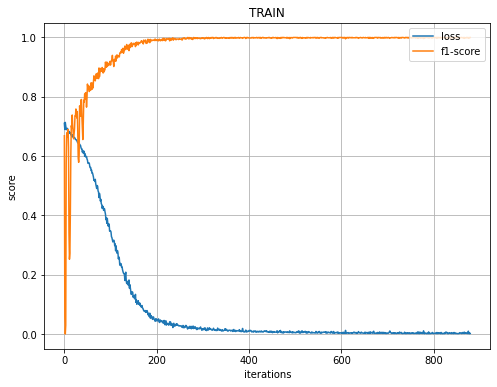

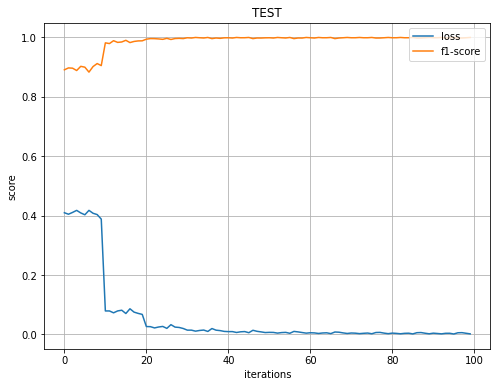

In [ ]:
show_results(train_loss, train_f1, val_loss, val_f1)

я решила все перезапустить и что-то произошло с CUDA.... остались только графики